
## Installs

Step 1: created conda env and installed rdkit (this installs the correct version of python)

* conda create -c conda-forge -n my-rdkit-env rdkit

Step 2:

* installed all other dependencies via pip



## Train a variational autoencoder to generate molecules.  

* the models use tensorflow

* needs GPU

In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"   ## force cpu only

import deepchem as dc
from deepchem.models.optimizers import ExponentialDecay
from deepchem.models.seqtoseq import AspuruGuzikAutoEncoder

import numpy as np
from rdkit import Chem
from random import shuffle

from rdkit.Chem import QED

from rdkit.Chem.Draw import IPythonConsole


2023-05-19 18:00:50.602304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 18:00:51.093333: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

batch_size = 100


In [3]:


tasks, datasets, transformers = dc.molnet.load_muv()
train_dataset, valid_dataset, test_dataset = datasets

train_smiles = train_dataset.ids     



In [4]:

print( len(train_smiles)  )


74469


In [5]:

'''
train_smiles = test_dataset.ids
shuffle(train_smiles)
train_smiles = train_smiles[:8000]

print( len(train_smiles)  )

'''


'\ntrain_smiles = test_dataset.ids\nshuffle(train_smiles)\ntrain_smiles = train_smiles[:8000]\n\nprint( len(train_smiles)  )\n\n'

In [6]:

print( train_smiles  )


['NC(=O)NC(Cc1ccccc1)C(=O)O' 'Nc1ccc(C(=O)O)c(O)c1'
 'C=CCNC(=S)Nc1ccc(Br)cc1F' ...
 'CC(=O)Nc1ccc(NC(=O)Cc2ccc(S(=O)(=O)N3CCCCC3)s2)cc1'
 'COc1ccc(N(C(=O)c2cccnc2)S(=O)(=O)c2cccs2)cc1'
 'COc1ccc(S(=O)(=O)N2CCCN(CCC(=O)Nc3cccc(C(F)(F)F)c3)CC2)cc1']


## Visualize a molecule

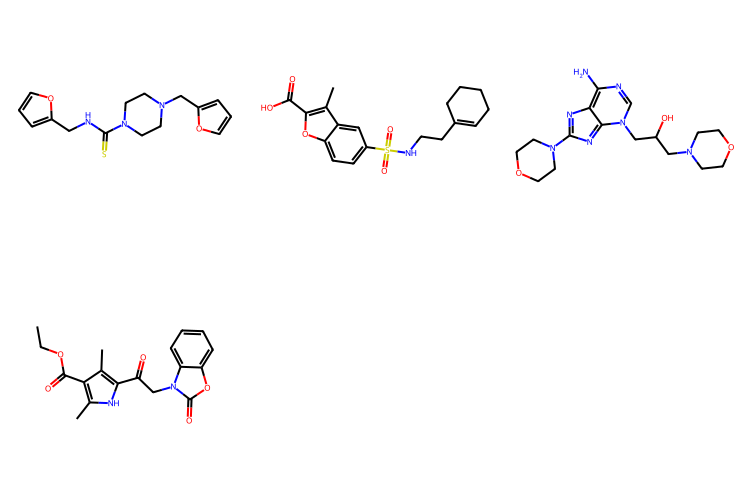

In [7]:

molecule_samples = ['S=C(NCc1ccco1)N1CCN(Cc2ccco2)CC1','Cc1c(C(=O)O)oc2ccc(S(=O)(=O)NCCC3=CCCCC3)cc12',
         'Nc1ncn(CC(O)CN2CCOCC2)c2nc(N3CCOCC3)nc1-2','CCOC(=O)c1c(C)[nH]c(C(=O)Cn2c(=O)oc3ccccc32)c1C' ]

molecule_samples_mol = [ Chem.MolFromSmiles(x) for x in molecule_samples]


Chem.Draw.MolsToGridImage(
          molecule_samples_mol,
          molsPerRow=3,
          subImgSize=(250, 250)
)



* Find the set of tokens that can appear
* and the maximum length of the SMILES strings we are working with.


In [8]:

tokens = set()

for s in train_smiles:
  tokens = tokens.union(set(s))

tokens = sorted(list(tokens))

max_length = max(len(s) for s in train_smiles)



## Build the model


In [9]:


batches_per_epoch = len(train_smiles)/batch_size

learning_rate     = ExponentialDecay(0.001, 0.95, batches_per_epoch)

model = AspuruGuzikAutoEncoder(
             tokens, 
             max_length, 
             model_dir='vae', 
             batch_size=batch_size, 
             learning_rate=learning_rate
)



2023-05-19 18:01:04.322183: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-19 18:01:04.322222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: MaquinaDeGuerra
2023-05-19 18:01:04.322229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: MaquinaDeGuerra
2023-05-19 18:01:04.322359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 460.91.3
2023-05-19 18:01:04.322383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 460.91.3
2023-05-19 18:01:04.322389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 460.91.3
2023-05-19 18:01:04.555420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executo


## Train the model


In [10]:


def generate_sequences(epochs):
  for i in range(epochs):
    print(i)
    for s in train_smiles:
      yield (s, s)

    

In [11]:

epochs = 20

model.fit_sequences(generate_sequences(epochs))


0


2023-05-19 18:01:16.597192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 18:01:16.598192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 18:01:16.598901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19




## Generate some new molecules


In [24]:

predictions = model.predict_from_embeddings(np.random.normal(size=(1000,196)))


In [25]:

molecules = []

for p in predictions:
  smiles = ''.join(p)
  if Chem.MolFromSmiles(smiles) is not None:
    molecules.append(smiles)


[22:14:10] SMILES Parse Error: duplicated ring closure 1 bonds atom 0 to itself for input: 'C=11ccccccccccccc1'
[22:14:10] SMILES Parse Error: unclosed ring for input: 'C=Cccccc1'
[22:14:10] SMILES Parse Error: unclosed ring for input: 'C=1cccccccCc11'
[22:14:10] SMILES Parse Error: duplicated ring closure 1 bonds atom 0 to itself for input: 'C=11cccccccccccccc11'
[22:14:10] SMILES Parse Error: extra open parentheses for input: 'C=C(ccccccccccccccccccccccc1'
[22:14:10] SMILES Parse Error: duplicated ring closure 1 bonds atom 26 to itself for input: 'C=C(cccccccccccccccccccccccc)c11'
[22:14:10] SMILES Parse Error: unclosed ring for input: 'C=C(ccccccccccccccccccccccccc)cc1'
[22:14:10] SMILES Parse Error: duplicated ring closure 1 bonds atom 1 to itself for input: 'CC11ccccccccccccc2cc11'
[22:14:10] SMILES Parse Error: unclosed ring for input: 'C=C(ccccccccccccccccccccccccc)cc1'
[22:14:10] SMILES Parse Error: duplicated ring closure 1 bonds atom 28 to itself for input: 'C=C(ccccccccccccc

In [26]:

print()
print('Generated molecules:')
for m in molecules:
  print(m)



Generated molecules:
C=C1cccccccccccc1
C=C1cccccccccccc1
C=1cccccccc1
C=C1cccccccccc1
C=1cccccccc1
C=C1cccccccccccc1
C=1cccccc1
C=C1cccccccccc1
C=1cccccc1
C=C1cccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccccccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccc1
C=C1cccccccccccc1
C=C1cccccccccc1
C=C1cccccccccccccccccc1
C=1cccccc1
C=C1cccccccccccccc1
C=1cccccccc1
C=C1cccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccc1
CCC1cccccccccccccccccc1
C=C1cccccccccccccccc1
C=C1cccccccccccccccc1
C=C1cccccccccccccccccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccccc1
C=C1cccccccccccccc1

C=C1cccccccccc1
C=C1cccccccccccccc1
C=1cccccccc1
C=C1cccccccccccc1
C=1cccccccc1
C=C1cccccccccccccccccccccccc1
C=C1cccccccccccccccccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccccc1
C=1ccccccCcc1
C=C1cccccccccccccc1
C=C1cccccccccccc1
C=C1cccccccccccc1
CCC1ccccccccccccccccc

In [27]:

print( molecules )


['C=C1cccccccccccc1', 'C=C1cccccccccccc1', 'C=1cccccccc1', 'C=C1cccccccccc1', 'C=1cccccccc1', 'C=C1cccccccccccc1', 'C=1cccccc1', 'C=C1cccccccccc1', 'C=1cccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccccccccccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccc1', 'C=C1cccccccccccccccccc1', 'C=1cccccc1', 'C=C1cccccccccccccc1', 'C=1cccccccc1', 'C=C1cccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccccc1', 'CCC1cccccccccccccccccc1', 'C=C1cccccccccccccccc1', 'C=C1cccccccccccccccc1', 'C=C1cccccccccccccccccccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccccccc1', 'C=C1cccccccccccccc1', '', 'C=C1cccccccccc1', 'C=C1cccccccccccccc1', 'C=1cccccccc1', 'C=C1cccccccccccc1', 'C=1cccccccc1', 'C=C1cccccccccccccccccccccccc1', 'C=C1cccccccccccccccccccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccccccccccc1', 'C=C1cccc

In [28]:

molecules_analysis = [ Chem.MolFromSmiles(x) for x in molecules]


In [29]:

## print( molecules_analysis )   


## Visualize

In [30]:
'''
Chem.Draw.MolsToGridImage(
          molecules_analysis,
          molsPerRow=3,
          subImgSize=(250, 250)
)
'''

'\nChem.Draw.MolsToGridImage(\n          molecules_analysis,\n          molsPerRow=3,\n          subImgSize=(250, 250)\n)\n'

## Analyze and Select molecules

In [31]:

print(    sorted(  [x.GetNumAtoms() for x in molecules_analysis]   )    )


[0, 7, 7, 7, 7, 9, 9, 9, 9, 9, 10, 12, 12, 12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16, 18, 18, 20, 21, 21, 26, 26, 26, 26, 28, 28]


In [32]:

good_mol_list = [x for x in molecules_analysis if x.GetNumAtoms() > 10 and x.GetNumAtoms() < 50 ]
print(   len(good_mol_list)   )


50



## Quantitative Estimate of drug likeness (QED score)


In [33]:

qed_list = [  Chem.QED.qed(x) for x in good_mol_list ]

final_mol_list = [ (a, b) for a, b in zip(good_mol_list, qed_list) if b > 0.2 ]


In [34]:

## final_mol_list



## Visualize


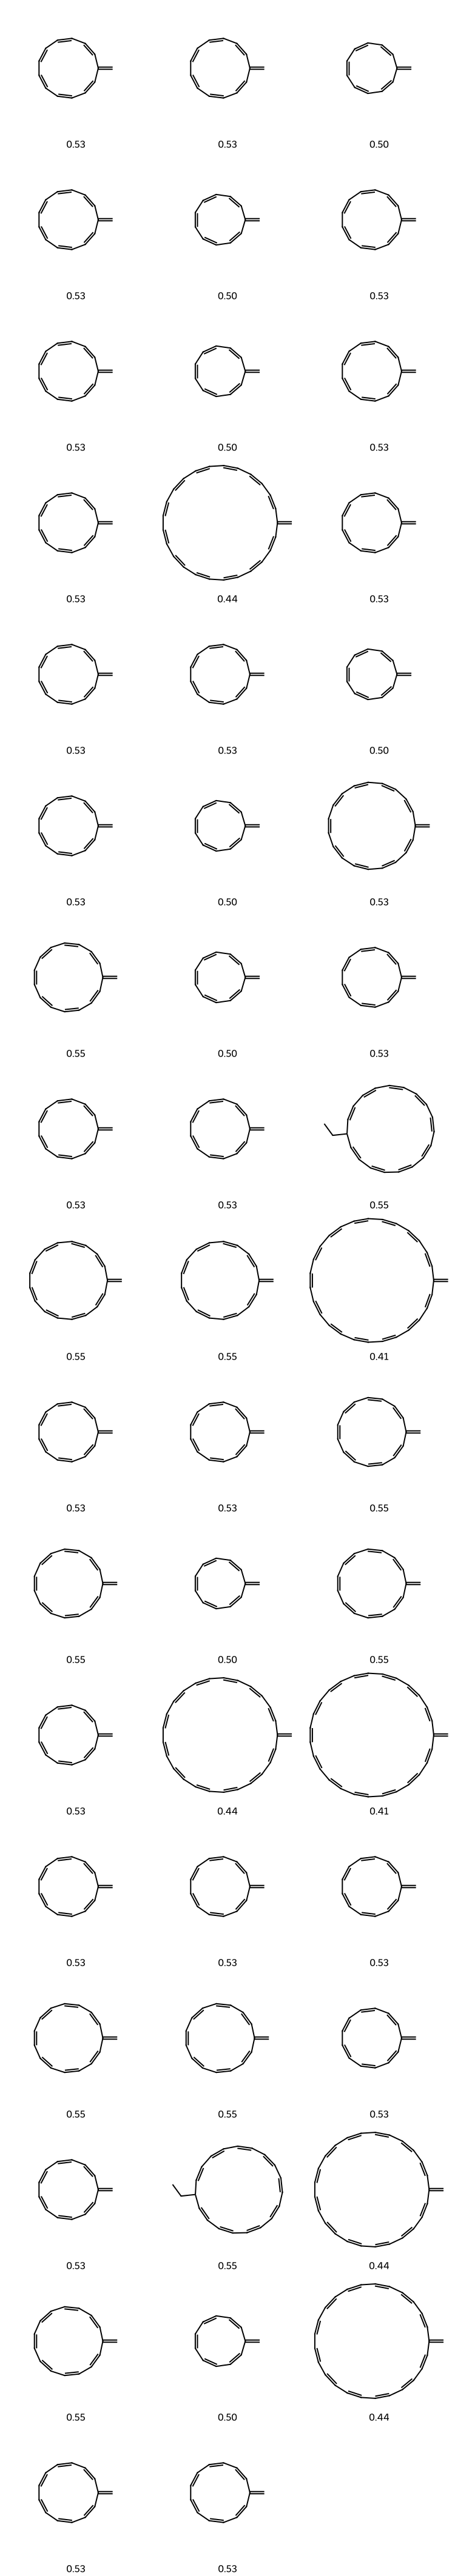

In [35]:

Chem.Draw.MolsToGridImage(
            [ x[0] for x in final_mol_list],
            molsPerRow=3,
            subImgSize=(250, 250),
            legends=[f"{x[1]:.2f}" for x in final_mol_list]
                          
)
